In [249]:
import torch
import numpy as np
from drlqap.qap import GraphAssignmentProblem
from drlqap import nn_configs, taskgenerators
from drlqap.simplesolver import solve_qap_backtracking
import matplotlib.pyplot as plt
import matplotlib
import bokeh
from bokeh.plotting import figure, show, gridplot
import drlqap.nn
from collections import defaultdict
import pandas as pd

In [201]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [191]:
# clear results
results = defaultdict(dict)

# Setup

In [29]:
base_args = dict(channels=32, encoder_depth=1, conv_depth=2)

nets = {
    "dense_none": lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm=None),
    "dense_ln":   lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='layer_norm'),
    "dense_bn":   lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='batch_norm'),
    "dense_kmn":   lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='keep_mean'),
    "dense_tmn":  lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='transformed_mean'),
    "dense_ms":   lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='mean_separation'),
    "dense_ms100x":   lambda: nn_configs.mpgnn_pairs(**base_args, conv_norm='mean_separation_100x'),
}

In [151]:
qap = taskgenerators.RandomWeightsTaskGenerator(8).sample()

# Test Networks

In [152]:
def create_net(name, base=None, seed=123):
    torch.manual_seed(seed)
    net = nets[name]()
    if base:
        missing, unexpected = net.load_state_dict(base.state_dict(), strict=False)
        assert(not unexpected)
        if missing:
            print(f"additional weights in {name}")
    return net

In [174]:
def show_output(net, qap):
    print(net.encoder.a_layers[0].q_conv.norm)
    with torch.no_grad():
        net_output = net(qap)
    net_embeddings = net.embeddings_a
    plt.imshow(net_embeddings[:,:16])
    plt.xlabel("Embedding index")
    plt.ylabel("Node")
    plt.yticks(range(qap.size))
    #plt.yticks(range(qap.size))
    plt.colorbar()
    plt.show()

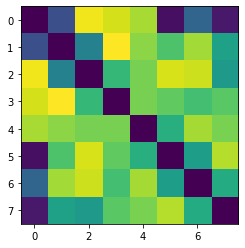

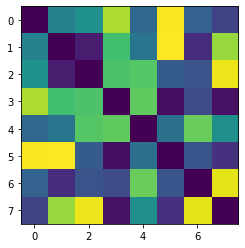

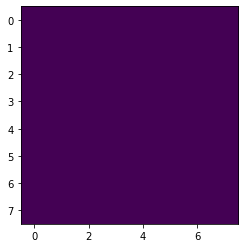

In [175]:
plt.imshow(qap.A) 
plt.show()
plt.imshow(qap.B) 
plt.show()
plt.imshow(qap.linear_costs) 
plt.show()

None


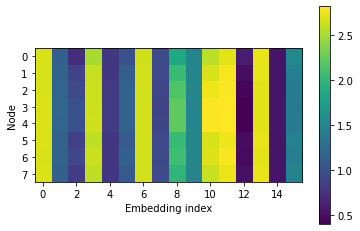

BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)


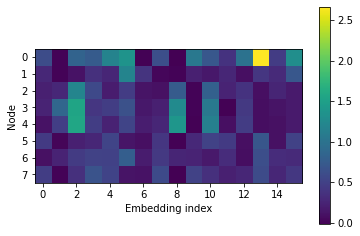

KeepMeanNorm()


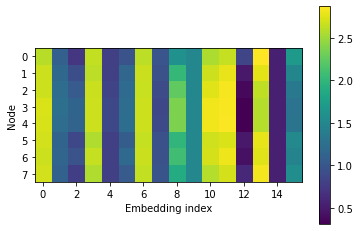

additional weights in dense_tmn
TransformedMeanNorm(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
)


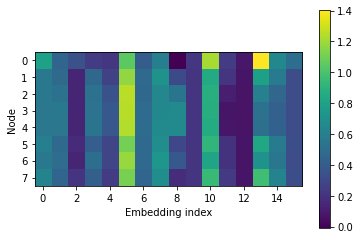

additional weights in dense_ms
MeanSeparationLayer(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
  (residual_linear): Linear(in_features=32, out_features=32, bias=True)
)


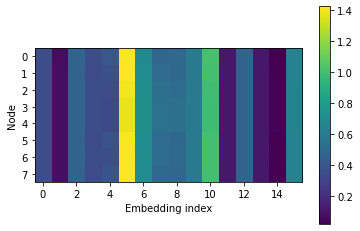

additional weights in dense_ms100x
MeanSeparationLayer(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
  (residual_linear): Linear(in_features=32, out_features=32, bias=True)
)


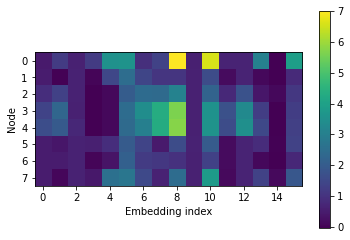

In [379]:
base_net = create_net("dense_none")
show_output(create_net("dense_none", base=base_net), qap)
show_output(create_net("dense_bn", base=base_net), qap)
show_output(create_net("dense_kmn", base=base_net), qap)
show_output(create_net("dense_tmn", base=base_net), qap)
show_output(create_net("dense_ms", base=base_net), qap)
show_output(create_net("dense_ms100x", base=base_net), qap)

# Target Matrix

In [12]:
# Solve QAP
optimal_value, optimal_assignment = solve_qap_backtracking(qap)

In [13]:
optimal_matrix = torch.eye(qap.size)[optimal_assignment]

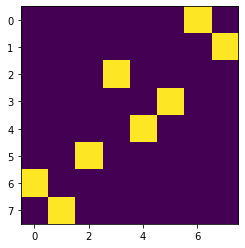

In [14]:
plt.imshow(optimal_matrix)

tensor(0.4644)


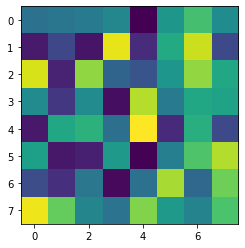

In [178]:
random_matrix = torch.rand((qap.size, qap.size))
print(random_matrix.mean())
plt.imshow(random_matrix)

tensor(0.1250)


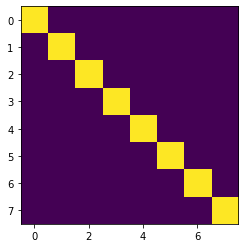

In [356]:
target_matrix = torch.eye(qap.size)
print(target_matrix.mean())
plt.imshow(target_matrix)

In [358]:
def train(net, epochs, lr, weight_decay=0):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)   
    losses = []
    target = target_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(qap)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [359]:
repetitions = 4
threshold = 0.03

def find_index_below(values, threshold):
    for i, x in enumerate(values):
        if x < threshold:
            return i
    return None

for seed in range(repetitions):
    base_net = create_net("dense_none", seed=seed)
    for name in nets:
        net = create_net(name, base=base_net, seed=seed)
        losses = train(net, 500, lr=1e-3)
        results[name][seed] = (net, losses)
        threshold_steps = find_index_below(losses, threshold)
        print(f"{name} done; {threshold_steps} until {threshold}; final loss: {losses[-1]}")

print("done")

dense_none done; None until 0.03; final loss: 0.10937502235174179
dense_ln done; None until 0.03; final loss: 0.109375
dense_bn done; 52 until 0.03; final loss: 3.3304823343627277e-09
dense_kmn done; 386 until 0.03; final loss: 0.003387038828805089
additional weights in dense_tmn
dense_tmn done; 178 until 0.03; final loss: 1.2995949873584323e-05
additional weights in dense_ms
dense_ms done; None until 0.03; final loss: 0.109375
additional weights in dense_ms100x
dense_ms100x done; 55 until 0.03; final loss: 1.8539700330499898e-10
dense_none done; None until 0.03; final loss: 0.10937503725290298
dense_ln done; None until 0.03; final loss: 0.1093750149011612
dense_bn done; 70 until 0.03; final loss: 6.156639574328437e-05
dense_kmn done; None until 0.03; final loss: 0.04967052862048149
additional weights in dense_tmn
dense_tmn done; 218 until 0.03; final loss: 1.1020564670616295e-05
additional weights in dense_ms
dense_ms done; None until 0.03; final loss: 0.109375
additional weights in d

# Loss curves

In [360]:
from bokeh.palettes import Dark2_8
from bokeh.models import Range1d
import itertools

fig = figure()

def moving_average(x, n=100) :
    return np.mean(sliding_window_view(x, window_shape=n), axis=-1)

palette = Dark2_8
average = False
for i, (name, net_runs) in enumerate(results.items()):
    x = range(len(net_runs[0][1]))
    color = palette[i % len(palette)]
    
    if average:
        average_loss = np.mean([run[1] for run in net_runs], axis=0)
        fig.line(x=x, y=average_loss, legend_label=name, color=Dark2_5[i])
    else:
        for seed, (net, loss) in net_runs.items():
            fig.line(x=x, y=loss, legend_label=name, color=color)

fig.y_range = Range1d(0,0.2)
fig.legend.click_policy = "hide"
show(fig)

In [361]:
def aggregate(df, key, window, agg):
        return df.groupby(key, sort=False).aggregate(agg).transpose().rolling(window).mean()

def generate_variation_plot(df, key, window, labels):
    mean = aggregate(df, key, window, 'mean')
    upper = aggregate(df, key, window, 'max')
    lower = aggregate(df, key, window, 'min')
    cmap = matplotlib.cm.get_cmap('tab10')
    count = len(mean.columns)
    for i, (index, label) in enumerate(labels.items()):
        color = cmap(i)
        #plt.fill_between(mean[col].index, lower[col], upper[col], alpha=0.1, color=color)
        matching_indices = (df.index.get_level_values(key) == index)
        individuals = df[matching_indices].transpose().rolling(window).mean()
        for i in individuals:
            plt.plot(individuals[i], alpha=0.2, linewidth=4, color=color)
        plt.plot(mean[index], label=label, color=color, linewidth=2)

In [362]:
labels = {
    'dense_none': 'No norm',
    'dense_bn': 'PairNorm',
    'dense_kmn': 'Keep Mean',
    'dense_tmn': 'Transformed Mean',
    'dense_ms': 'Mean Separation',
    'dense_ms100x': 'Mean Separation (scaled x100)',
}

In [363]:
values = [values for name, net_results in results.items() for seed, (net, values) in net_results.items()]
indices = [(name, seed) for name, net_results in results.items() for seed, (net, values) in net_results.items()]
df = pd.DataFrame(values, index=pd.MultiIndex.from_tuples(indices, names=['name', 'seed']))

(0.0, 0.12)

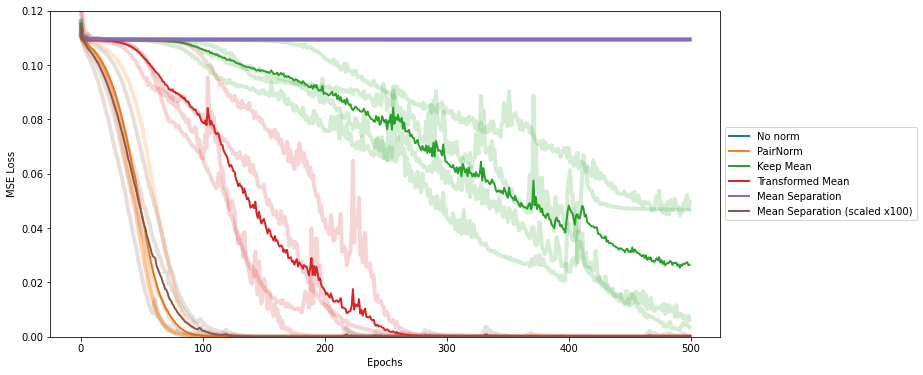

In [378]:
plt.figure(figsize=(12,6))
generate_variation_plot(df.query("name != 'dense_ln'"), 'name', 1, labels)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.ylim(0, 0.12)

In [365]:
results["dense_none"][0]

(QAPNet(
   (encoder): DenseQAPEncoder(
     (a_layers): ModuleList(
       (0): QapConvLayer(
         (q_conv): ConvLayer(
           (edge_encoder): Sequential(
             (linear[0](1->32)): Linear(in_features=1, out_features=32, bias=True)
             (activation[0]): LeakyReLU(negative_slope=0.01)
             (linear[1](32->32)): Linear(in_features=32, out_features=32, bias=True)
             (activation[1]): LeakyReLU(negative_slope=0.01)
           )
           (transformation): Sequential(
             (linear[0](32->32)): Linear(in_features=32, out_features=32, bias=True)
             (activation[0]): LeakyReLU(negative_slope=0.01)
           )
         )
         (l_conv): ConvLayer(
           (edge_encoder): Sequential(
             (linear[0](1->32)): Linear(in_features=1, out_features=32, bias=True)
             (activation[0]): LeakyReLU(negative_slope=0.01)
             (linear[1](32->32)): Linear(in_features=32, out_features=32, bias=True)
             (activation

# Outputs

In [375]:
grid = []

for name, net_results in results.items():
    gridrow = []
    for i, (net, losses) in net_results.items():
        with torch.no_grad():
            net_output = net(qap)
        data = dict(value=[net_output.numpy()])
        fig = figure(
            title=name,
            tools="hover",
            tooltips=[("Value", "@value")]
        )
        fig.image(
            source=data, 
            image="value",
            x=0, y=0, 
            dw=qap.size, dh=qap.size, 
            color_mapper=bokeh.models.LinearColorMapper(low=0, high=1, palette="Viridis256")
        )
        gridrow.append(fig)
    grid.append(gridrow)
show(gridplot(grid, sizing_mode="scale_width"))

# QAPConvLayer in isolation